## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import numpy as np
import pandas as pd
import random
import tensorflow as tf
import isuelogit as isl
import glob
import time

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/nesuelogit


In [3]:
from pesuelogit.visualizations import plot_convergence_estimates
from pesuelogit.networks import load_k_shortest_paths, read_paths, build_fresno_network, \
    Equilibrator, sparsify_OD, ColumnGenerator, read_OD
from pesuelogit.etl import get_design_tensor, get_y_tensor, data_curation, temporal_split, add_period_id, get_tensors_by_year
from pesuelogit.models import compute_rr

# Internal modules
from nesuelogit.models import NESUELOGIT, ODParameters, UtilityParameters, BPR, MLP, KernelConstraint, \
    GenerationParameters, train_val_split_by_links, train_kfold, compute_generated_trips, compute_generation_factors, \
    create_inference_model, compute_benchmark_metrics, PolynomialLayer, bpr_function
from nesuelogit.visualizations import  plot_predictive_performance, plot_metrics_kfold, plot_top_od_flows_periods, \
    plot_utility_parameters_periods, plot_rr_by_period, plot_rr_by_period_models, plot_total_trips_models, \
    plot_mlp_performance_functions, plot_flow_vs_traveltime
from nesuelogit.metrics import mse, btcg_mse, mnrmse, mape, nrmse, r2, zscore, z2score
from nesuelogit.utils import read_paths

In [4]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

## Build Fresno network

In [6]:
fresno_network = build_fresno_network()

## Read OD matrix

In [7]:
read_OD(network=fresno_network, sparse=True)

Matrix Q (1789, 1789) read in 0.0[s] with sparse format
66266.3 trips were loaded among 6970 o-d pairs



## Read paths

In [8]:
#read_paths(network=fresno_network, update_incidence_matrices=True, filename='paths-fresno.csv')
read_paths(network=fresno_network, update_incidence_matrices=True, filename = 'paths-full-model-fresno.csv')

# For quick testing
# Q = fresno_network.load_OD(sparsify_OD(fresno_network.Q, prop_od_pairs=0.99))
# load_k_shortest_paths(network=fresno_network, k=2, update_incidence_matrices=True)

Paths were read


## Read spatiotemporal data

In [9]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
# Select data from Tuesday to Thursday
df = df[df['date'].dt.dayofweek.between(1, 3)]
# df = df[df['date'].dt.year == 2019]
# Select data from Wednesday only
#df = df[df['date'].dt.dayofweek.between(2, 2)]

# Select data from one day only
#df = df[df['date'] == "2019-10-02"]


In [10]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


In [11]:
df.head()

,link_key,observed,counts,capacity [veh],tt_ff [min],speed_ff[mi/hr],inrix_id,pems_ids,link_type,id,...,median_age,incidents,bus_stops,intersections,date,hour,tf_inrix,year,period,period_id
0,"(0, 1621, '0')",0,NaN,1800.0,0.098,45,1.626616e+09,[],LWRLK,1,...,31.1,0,0,1,2019-10-01,10,0.221,2019,2019-10-01-10,4
1,"(1239, 1630, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,565,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
2,"(228, 192, '0')",1,1667.0,2400.0,0.110,65,1.626659e+09,[602350],LWRLK,564,...,16.6,0,0,0,2019-10-01,10,0.112,2019,2019-10-01-10,4
3,"(1243, 1631, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,563,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4
4,"(1244, 1632, '0')",0,NaN,inf,0.000,99999,NaN,[],DMDLK,562,...,0.0,0,0,0,2019-10-01,10,0.000,2019,2019-10-01-10,4


In [12]:
# Units in miles per hour
df[['speed_ref_avg','speed_hist_avg','speed_max']].describe()

,speed_ref_avg,speed_hist_avg,speed_max
count,1.013460e+06,1.009583e+06,1.013460e+06
mean,1.924470e+01,1.767589e+01,2.051278e+01
std,1.982261e+01,1.909664e+01,2.140424e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.112700e+01,1.755400e+01,2.112700e+01
75%,2.796200e+01,2.547600e+01,3.106900e+01
max,6.772900e+01,7.891400e+01,8.388500e+01


In [13]:
df.columns

Index(['link_key', 'observed', 'counts', 'capacity [veh]', 'tt_ff [min]',
       'speed_ff[mi/hr]', 'inrix_id', 'pems_ids', 'link_type', 'id', 'rhoj',
       'lane', 'ff_speed', 'length', 'alpha', 'beta', 'tf', 'k', 'inrix_id.1',
       'speed_avg', 'speed_ref_avg', 'speed_hist_avg', 'tt_avg', 'speed_max',
       'speed_sd', 'speed_cv', 'speed_hist_sd', 'speed_ref_sd', 'tt_sd',
       'tt_var', 'tt_cv', 'road_closures', 'median_inc', 'median_age',
       'incidents', 'bus_stops', 'intersections', 'date', 'hour', 'tf_inrix',
       'year', 'period', 'period_id'],
      dtype='object')

## Data curation

In [14]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

tt_sd_adj = df.groupby(['period_id','link_key'])[['tt_avg']].std().reset_index().rename(columns = {'tt_avg': 'tt_sd_adj'})

df = df.merge(tt_sd_adj, on = ['period_id','link_key'])

df = data_curation(df)

df['tt_sd'] = df['tt_sd_adj']

In [15]:
# Units of travel time features are converted from hours to minutes
df['tt_sd'] = df['tt_sd']*60
df['tt_avg'] = df['tt_avg']*60
df['tt_ff'] = df['tt_ff']*60

In [16]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg','tt_sd_adj']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg,tt_sd_adj
count,1.013460e+06,1.009583e+06,1.013460e+06,887813.000000,1.013460e+06
mean,1.924470e+01,1.767589e+01,2.038423e-01,0.219493,3.022799e-04
std,1.982261e+01,1.909664e+01,2.610045e-01,0.262030,4.638521e-04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,2.112700e+01,1.755400e+01,1.497376e-01,0.167050,1.856268e-04
75%,2.796200e+01,2.547600e+01,2.792397e-01,0.312986,4.248116e-04
max,6.772900e+01,7.891400e+01,4.220601e+00,3.827439,1.243267e-02


## Node data

In [17]:
node_data = pd.read_csv(isl.config.dirs['read_network_data'] + 'nodes/fresno-nodes-gis-data.csv')
node_data['population'] = node_data['pop_tract']#/node_data['nodes_tract']
#TODO: Compute area of each census tract and normalize number of stops for that
# node_data['bus_stops'] = node_data['stops_tract']/node_data['pop_tract']
node_data['bus_stops'] = node_data['stops_tract']#/node_data['nodes_tract']
node_data['income'] = node_data['median_inc']

In [18]:
features_generation = ['population','income', 'bus_stops']

node_data = node_data[['key','type'] + features_generation]

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(node_data[features_generation])
node_data[features_generation] = imp_mean.transform(node_data[features_generation])

scaler = preprocessing.StandardScaler().fit(node_data[features_generation].values)
# scaler = preprocessing.MinMaxScaler().fit(node_data[features_generation].values)
node_data[features_generation] = scaler.transform(node_data[features_generation].values)

## Utility function

In [19]:
_FEATURES_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']
# _FEATURES_Z = ['tt_sd']
# _FEATURES_Z = []

## Data processing

In [20]:
n_links = len(fresno_network.links)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year
X, Y = {}, {}

In [21]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.204903,0.221931,0.200169,0.018137
std,770.228931,0.262226,0.266852,0.228208,0.027831
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.150455,0.168820,0.152000,0.011138
75%,2162.450000,0.282111,0.318261,0.280000,0.025489
max,4807.000000,4.220601,3.827439,2.302000,0.745960


In [22]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'tt_sd']].describe()

,counts,tt_ff,tt_avg,tf_inrix,tt_sd
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.202618,0.216770,0.198494,0.018137
std,743.713869,0.259583,0.256512,0.226003,0.027831
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.149437,0.165341,0.150000,0.011138
75%,1978.000000,0.274658,0.306717,0.273000,0.025489
max,4766.000000,4.220601,3.274444,2.113000,0.745960


In [23]:
# Set free flow travel times
tt_ff_links = df.groupby('link_key')['tt_ff'].min()
for link in fresno_network.links:
    fresno_network.links_dict[link.key].performance_function.tf = float(tt_ff_links[tt_ff_links.index==str(link.key)].iloc[0])

In [24]:
# This correlation should be positive
df[['counts','tt_avg']].corr()

,counts,tt_avg
counts,1.000000,0.055122
tt_avg,0.055122,1.000000


## EDA

In [25]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [26]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Link attributes

In [27]:
df[_FEATURES_Z].describe()

,tt_sd,median_inc,incidents,bus_stops,intersections
count,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06,1.013460e+06
mean,1.813680e-02,2.621913e+01,7.441093e-01,1.500207e-01,8.765023e-01
std,2.783112e-02,2.135738e+01,3.193143e+00,4.411927e-01,1.319496e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.113761e-02,2.482100e+01,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.548870e-02,4.168100e+01,0.000000e+00,0.000000e+00,1.000000e+00
max,7.459602e-01,1.158930e+02,4.000000e+01,4.000000e+00,9.000000e+00


## Training and validation sets

In [28]:
_DTYPE = tf.float32

# Data between 4pm and 5pm to estimate LUE, ODLUE and ODLULPE models
X, Y = get_tensors_by_year(df[df.hour.isin([16])], features_Z = _FEATURES_Z, network = fresno_network)

# Hourly data DURING morning and afternoon peak hour windows (6 hour intervals) to estimate TVODLULPE
XT, YT = get_tensors_by_year(df[df.hour.isin([6,7,8, 15,16,17])], features_Z = _FEATURES_Z, network = fresno_network)

# Split in training and test sets
X_train, X_val, Y_train, Y_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [X[2019], X[2020], Y[2019], Y[2020]])
XT_train, XT_val, YT_train, YT_val = map(lambda x: tf.cast(x, dtype = _DTYPE), [XT[2019], XT[2020], YT[2019], YT[2020]])

## Configuration

In [75]:
_LOSS_WEIGHTS ={'od': 0, 'traveltime': 0, 'flow': 1, 'equilibrium': 1}
_EQUILIBRIUM_STAGE = True
_ALTERNATING_OPTIMIZATION = False

_LR = {'learning': 1e-1, 'equilibrium': 1e-1}

_BATCH_SIZE = 1 #16
_EPOCHS = {'learning': 40, 'equilibrium': 10}
# _EPOCHS = {'learning': 2, 'equilibrium': 1}
# _XTICKS_SPACING = 2
_XTICKS_SPACING = 5
_EPOCHS_PRINT_INTERVAL = {'learning':1, 'equilibrium':1}

_RELATIVE_GAP = 1e-2

_FIXED_EFFECT = False

# _LOSS_METRIC  = mnrmse
# _LOSS_METRIC  = nrmse
# _LOSS_METRIC  = zscore
_LOSS_METRIC  = z2score

# With GPU
_OPTIMIZERS = {'learning': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['learning']),
              'equilibrium': tf.keras.optimizers.legacy.Adam(learning_rate=_LR['equilibrium'])
              }

## Models

In [76]:
train_results_dfs = {}
val_results_dfs = {}
models = {}

In [77]:
def create_mlp(network, dtype =_DTYPE):
    return MLP(n_links=len(network.links),
                           free_flow_traveltimes=[link.bpr.tf for link in network.links],
                           capacities=[link.bpr.k for link in network.links],
                           kernel_constraint=KernelConstraint(
                               link_keys=[(link.key[0], link.key[1]) for link in network.links],
                               adjacency_constraint=True,
                               dtype=dtype,
                               capacities=[link.bpr.k for link in network.links],
                               free_flow_traveltimes=[link.bpr.tf for link in network.links],
                               diagonal=False,
                               symmetric=True,
                           ),
                           trainable = True,
                           polynomial_layer= PolynomialLayer(poly_order=4, trainable = True, pretrain_weights=True,
                                                             alpha_prior = 1, beta_prior = 2,
                                                             kernel_constraint=tf.keras.constraints.NonNeg(),
                                                             ),
                           alpha_relu = 0.1,
                           depth=1,
                           dtype=dtype)

def create_bpr(network, dtype =_DTYPE):
    return BPR(keys=['alpha', 'beta'],
               # initial_values={'alpha': 1, 'beta': 1}, # Consistent with MLP initialization
               initial_values={'alpha': 0.15 * tf.ones(len(network.links), dtype = dtype),
                               'beta': 4 * tf.ones(len(network.links), dtype = dtype)},
               trainables={'alpha': True, 'beta':True},
               capacities = [link.bpr.k for link in network.links],
               free_flow_traveltimes =[link.bpr.tf for link in network.links],
               dtype = dtype
               )

def create_tvodlulpe_model_fresno(network, dtype = _DTYPE, n_periods=1, features_Z = _FEATURES_Z, historic_g = None,
                                  performance_function = None):

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           # initial_values={
                                           #                 'tt': -10,
                                           #                 'tt_sd': -10, 'median_inc': 1,
                                           #                 'incidents': -1, 'bus_stops': -1, 'intersections': -1,
                                           #                 'psc_factor': 0,
                                           #                 'fixed_effect': np.zeros_like(network.links)},
                                           initial_values={
                                               'tt': -3.0597,
                                               'tt_sd': -3.2678, 'median_inc': 0,
                                               'incidents': -4.5368, 'bus_stops': 0, 'intersections': -3.8788,
                                               'psc_factor': 0,
                                               'fixed_effect': np.zeros_like(network.links)},

                                           signs={'tt': '-', 'tt_sd': '-', 'median_inc': '+', 'incidents': '-',
                                                  'bus_stops': '-', 'intersections': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': True,
                                                       'tt': True, 'tt_sd': True, 'median_inc': True,
                                                       'incidents': True,
                                                       'bus_stops': True, 'intersections': True
                                                       },
                                           time_varying=True,
                                           dtype=dtype
                                           )

    if performance_function is None:
        # performance_function = create_bpr(network = network, dtype = dtype)
        performance_function = create_mlp(network = network, dtype = dtype)

    od_parameters = ODParameters(key='od',
                                 initial_values=network.q.flatten(),
                                 # historic_values={10: network.q.flatten()},
                                 # total_trips={0: 1e5, 1: 1e5, 2: 1e5, 9: 1e5, 10: 1e5, 11: 1e5},
                                 ods=network.ods,
                                 n_periods=n_periods,
                                 time_varying=True,
                                 trainable=True,
                                 )

    # TODO: Add option to pretrain weights
    generation_parameters = GenerationParameters(
        features_Z=['population', 'income', 'bus_stops'],
        keys=['fixed_effect_od', 'fixed_effect_origin', 'fixed_effect_destination'],
        # initial_values={'income': 1e2, 'population': 1e2, 'bus_stops': -1e2 ,
        #                 # 'fixed_effect': od_parameters.compute_generated_trips()*generation_factors
        #                 # 'fixed_effect': od_parameters.compute_generated_trips()
        #                 },
        signs={'income': '+', 'population': '+', 'bus_stops': '-'},
        trainables={'fixed_effect': True, 'income': True, 'population': True, 'bus_stops': True,
                    'fixed_effect_origin': False, 'fixed_effect_destination': False, 'fixed_effect_od': True
                    # 'fixed_effect_origin': False, 'fixed_effect_destination': True, 'fixed_effect_od': False
                    },
        # trainables={'fixed_effect': True, 'income': True, 'population': True, 'bus_stops': True},
        # trainables={'fixed_effect': False, 'income': False, 'population': False, 'bus_stops': False},
        time_varying=True,
        # historic_g = od_parameters.compute_generated_trips(),
        historic_g= historic_g,
        pretrain_generation_weights=True,
        dtype=dtype
    )

    model = NESUELOGIT(
        key='tvodlulpe',
        network=network,
        dtype=dtype,
        utility=utility_parameters,
        performance_function=performance_function,
        od=od_parameters,
        generation=generation_parameters,
        n_periods=n_periods
    )

    return model, {'utility_parameters': utility_parameters, 'generation_parameters': generation_parameters,
                   'od_parameters': od_parameters, 'performance_function': performance_function}

### TVODLULPE

In [78]:
print('\ntvodlulpe: Time specific utility and OD, link performance parameters')

# To report runtime
t0 = time.time()

#growth_factor = 1

# Total trips tvodlulpe pesuelogit:
# Epoch 0: 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04 6.6e+04
# Final epoch: 6.4e+04 6.6e+04 6.3e+04 7.8e+04 7.9e+04 7.9e+04
growth_factor = 7.9/6.6

generation_factors = growth_factor*compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q = fresno_network.q.flatten()[np.newaxis,:], ods= fresno_network.ods)

models['tvodlulpe'], _ = create_tvodlulpe_model_fresno(
    n_periods = n_periods, network = fresno_network, historic_g= generated_trips * generation_factors.values[:, np.newaxis])

train_results_dfs['tvodlulpe'], val_results_dfs['tvodlulpe'] = models['tvodlulpe'].fit(
    XT_train, YT_train, XT_val, YT_val,
    node_data=node_data,
    optimizers=_OPTIMIZERS,
    # generalization_error={'train': False, 'validation': True},
    batch_size=_BATCH_SIZE,
    loss_weights= _LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    alternating_optimization=_ALTERNATING_OPTIMIZATION,
    threshold_relative_gap=_RELATIVE_GAP,
    epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
    epochs=_EPOCHS)


tvodlulpe: Time specific utility and OD, link performance parameters

Model training

Pretraining generation weights

period 0 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 1 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 2 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 3 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 4 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}
period 5 -> p-values kappa: {'population': 0.0017, 'income': 0.5592, 'bus_stops': 0.341}

 Benchmark metrics using mean in training data as predictions:  

    component    value metric
0        flow       57   mape
1  traveltime       55   mape
0        flow    6e+05    mse
1  traveltime    0.063    mse
0        flow   -0.057     r2
1  traveltime -0.00022     r2

hyperparameters loss function: {'od': 0, 'traveltime': 0, 'flow': 1, 

In [39]:
models['tvodlulpe'].performance_function

In [40]:
# Save model weights for prediction analyses
models['tvodlulpe'].save_weights(models['tvodlulpe']._filepath_weights)

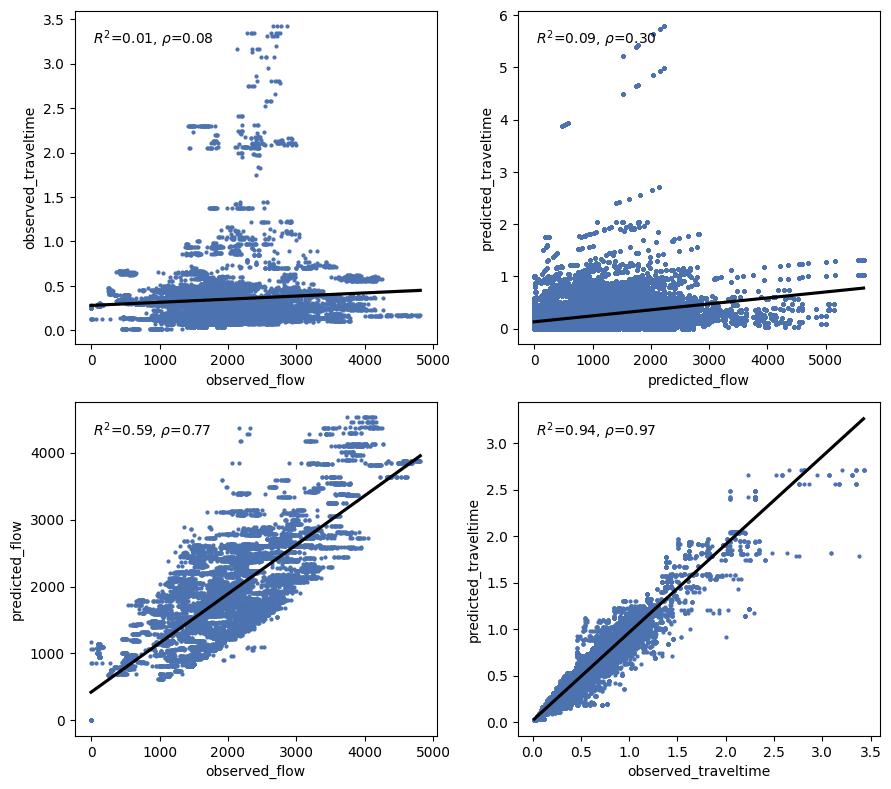

In [44]:
plot_flow_vs_traveltime(model = models['tvodlulpe'],
                        observed_traveltime=models['tvodlulpe'].mask_observed_traveltime(YT_train[:, :, 0]),
                        observed_flow= models['tvodlulpe'].mask_observed_flow(YT_train[:,:,1]),
                        scatter_kws={"color": sns.color_palette("deep")[0], 's':4, 'alpha': 1}, line_kws={"color": "black"},
                        all_metrics = False
                        )

plt.show()

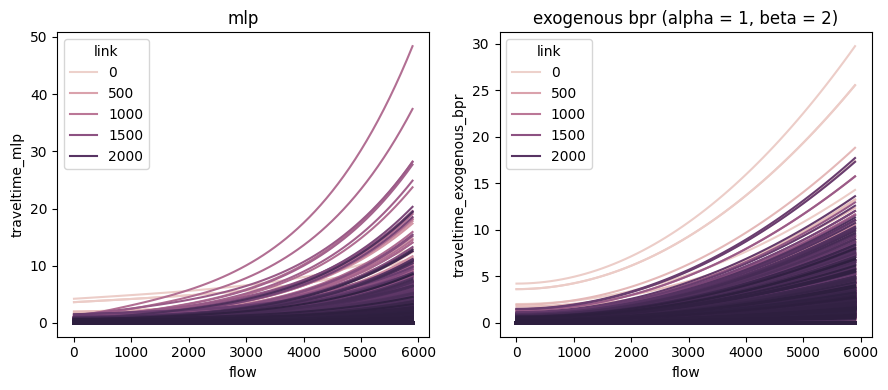

In [46]:
plot_mlp_performance_functions(model = models['tvodlulpe'],
                           network = fresno_network,
                           marginal = False,
                           alpha = 1,
                           beta = 2,
                           flow_range = range(0,6000,100)
                           )
plt.show()

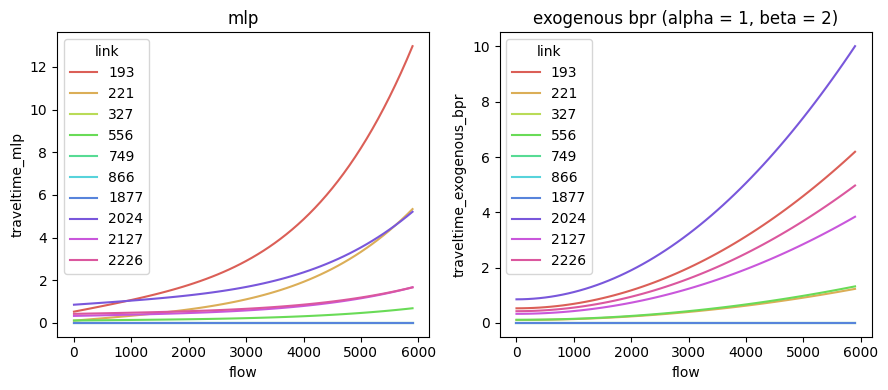

In [47]:
selected_links = np.random.choice(range(fresno_network.get_n_links()), 10, replace=False)

plot_mlp_performance_functions(model = models['tvodlulpe'],
                           network = fresno_network,
                           marginal = False,
                           selected_links = selected_links,
                           alpha = 1,
                           beta = 2,
                           flow_range = range(0,6000,100),
                           palette = sns.color_palette("hls", len(selected_links))
                           )
plt.show()

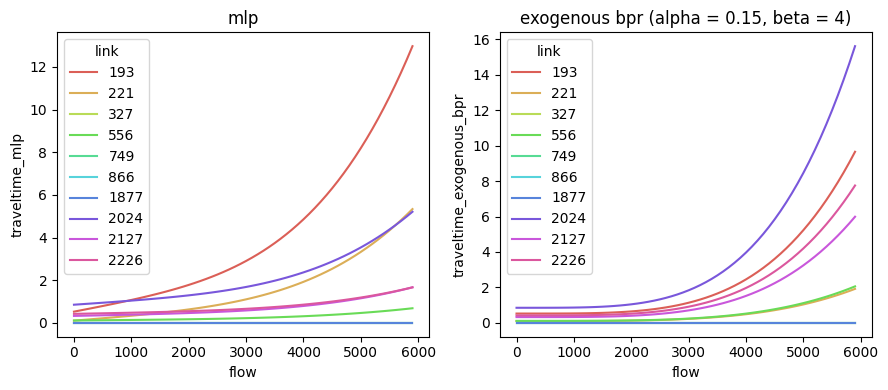

In [48]:
plot_mlp_performance_functions(model = models['tvodlulpe'],
                           network = fresno_network,
                           marginal = False,
                           selected_links = selected_links,
                           alpha = 0.15,
                           beta = 4,
                           flow_range = range(0,6000,100),
                           palette = sns.color_palette("hls", len(selected_links))
                           )
plt.show()

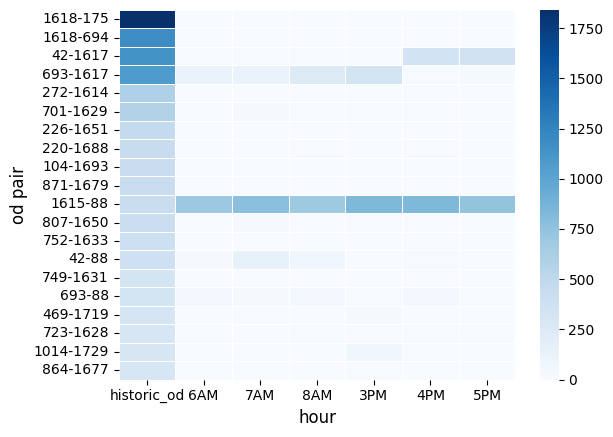

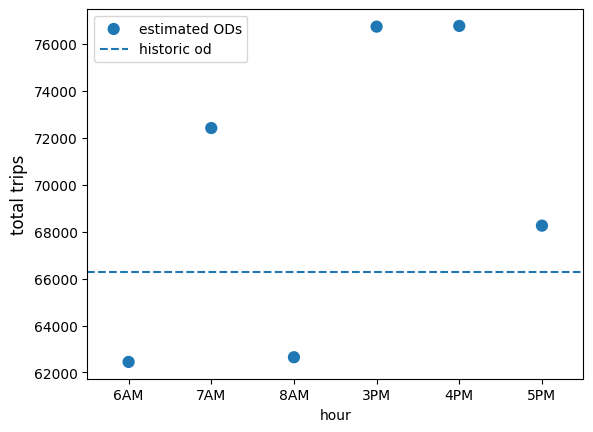

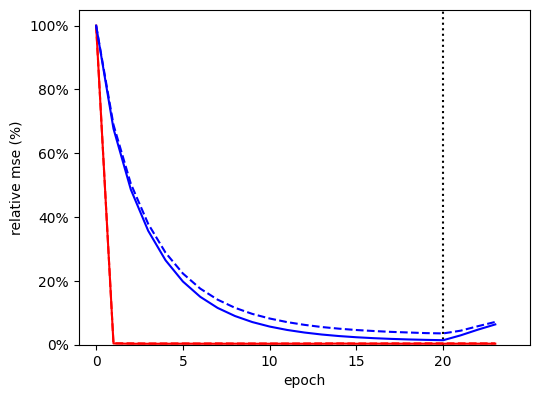

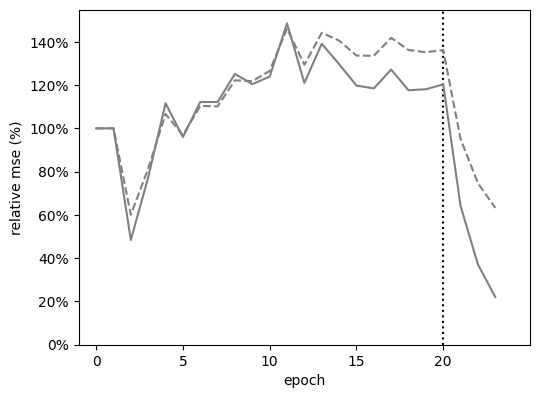

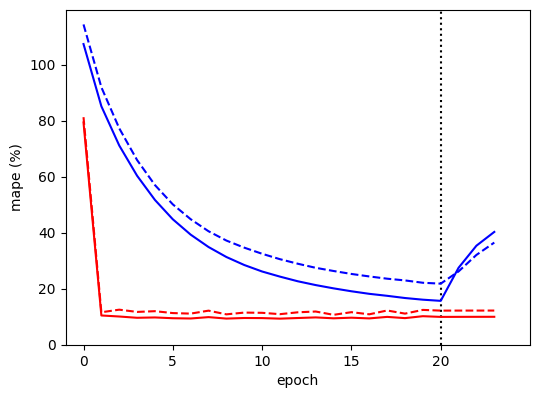

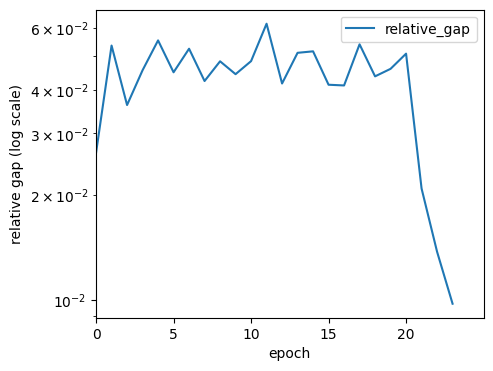

             tt     tt_sd  median_inc  incidents  bus_stops  intersections   
6-7   -3.058122 -3.803897         0.0  -4.088016  -0.097936      -4.813629  \
7-8   -1.935945 -2.924596         0.0  -6.102058   0.000000      -4.044578   
8-9   -1.770179 -0.935547         0.0  -6.156677   0.000000      -3.986116   
15-16 -2.000742 -3.718724         0.0  -3.991909   0.000000      -4.485475   
16-17 -2.634040 -3.640051         0.0  -6.777321   0.000000      -4.152614   
17-18 -2.534525 -1.742328         0.0  -5.414931  -1.177267      -4.486997   

       hour  
6-7       6  
7-8       7  
8-9       8  
15-16    15  
16-17    16  
17-18    17  


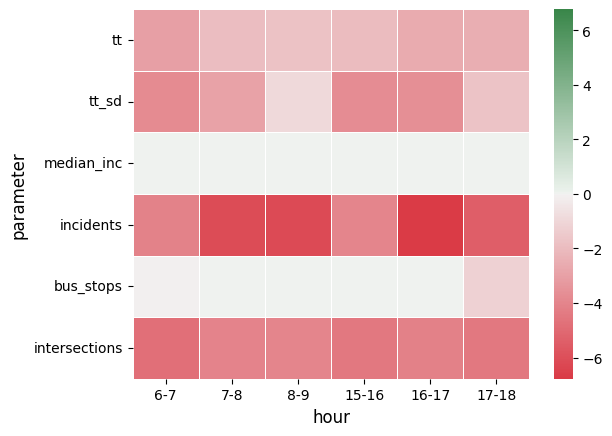

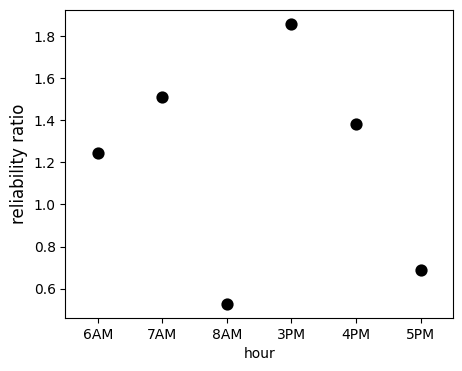

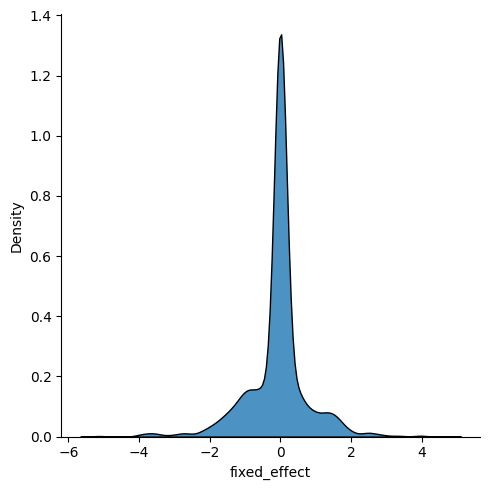

In [49]:
# Plot heatmap with flows of top od pairs
plot_top_od_flows_periods(models['tvodlulpe'],
                          historic_od= fresno_network.q.flatten(),
                          period_keys = period_keys,
                          period_feature='hour', top_k=20)

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage = _EPOCHS['learning']
                            )

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            curves=['equilibrium'],
                            epochs_end_learning_stage=_EPOCHS['learning'])

plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
                            xticks_spacing=_XTICKS_SPACING, show_validation=True,
                            curves=['travel time', 'link flow'],
                            epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
                            yaxis_label='mape (%)')

# plot_predictive_performance(train_losses=train_results_dfs['tvodlulpe'], val_losses=val_results_dfs['tvodlulpe'],
#                             xticks_spacing=_XTICKS_SPACING, show_validation=True,
#                             epochs_end_learning_stage=_EPOCHS['learning'], prefix_metric='mape',
#                             curves=['equilibrium'],
#                             yaxis_label='mape (%)')

fig, ax = plot_convergence_estimates(
    estimates=train_results_dfs['tvodlulpe'].assign(
        relative_gap=np.abs(train_results_dfs['tvodlulpe']['relative_gap']))[['epoch', 'relative_gap']],
    xticks_spacing=_XTICKS_SPACING)

ax.set_yscale('log')
ax.set_ylabel('relative gap (log scale)')

plt.show()

if models['tvodlulpe'].performance_function.type == 'bpr':

    plot_convergence_estimates(estimates=train_results_dfs['tvodlulpe'][['epoch', 'alpha', 'beta']],
                               xticks_spacing=_XTICKS_SPACING)

    sns.displot(pd.melt(pd.DataFrame({'alpha':models['tvodlulpe'].performance_function.alpha,
                                      'beta': models['tvodlulpe'].performance_function.beta}), var_name = 'parameters'),
                x="value", hue="parameters", multiple="stack", kind="kde", alpha = 0.8)

    plt.show()

# Compute utility parameters over time (heatmap) and value of travel time reliability (lineplot)
theta_df = plot_utility_parameters_periods(models['tvodlulpe'], period_keys = period_keys, period_feature='hour')

print(theta_df)
#print(theta_df.values)

plot_rr_by_period(models['tvodlulpe'], period_keys, period_feature='hour')

sns.displot(pd.DataFrame({'fixed_effect': np.array(models['tvodlulpe'].fixed_effect)}),
            x="fixed_effect", multiple="stack", kind="kde", alpha=0.8)

plt.show()

In [50]:
# MLP weights
mlp_weights = models['tvodlulpe'].performance_function.weights

mlp_weights

[<tf.Variable 'dense_5/kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[0.3558],
        [0.0225],
        [0.0126],
        [0.0252]], dtype=float32)>,
 <tf.Variable 'dense_4/kernel:0' shape=(2413, 2413) dtype=float32, numpy=
 array([[ 0.9871,  0.    , -0.    , ..., -0.    , -0.    ,  0.    ],
        [ 0.    ,  1.7657, -0.0003, ..., -0.    , -0.    ,  0.    ],
        [-0.    , -0.0003,  0.9948, ..., -0.    , -0.    ,  0.    ],
        ...,
        [-0.    , -0.    , -0.    , ...,  0.4126, -0.    ,  0.    ],
        [-0.    , -0.    , -0.    , ..., -0.    ,  0.4203,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  1.    ]],
       dtype=float32)>]

In [51]:
# TODO: Add plot of kernel matrix here

non_diagonal_mlp_weights = mlp_weights[1].numpy()[~np.eye(mlp_weights[1].shape[0], dtype=bool)]
100*len(non_diagonal_mlp_weights[(non_diagonal_mlp_weights>0)])/len(non_diagonal_mlp_weights)

0.11831297992699852

In [52]:
print(f"theta = "
      f"{dict(zip(models['tvodlulpe'].utility.true_values.keys(), list(np.mean(models['tvodlulpe'].theta.numpy(), axis=0))))}")
print(f"kappa= "
      f"{dict(zip(models['tvodlulpe'].generation.features, list(np.mean(models['tvodlulpe'].kappa.numpy(), axis=0))))}")

if models['tvodlulpe'].performance_function.type == 'bpr':
    print(f"alpha = {np.mean(models['tvodlulpe'].performance_function.alpha): 0.2f}, "
          f"beta  = {np.mean(models['tvodlulpe'].performance_function.beta): 0.2f}")

print(f"Avg abs diff of observed and estimated OD: "
      f"{np.mean(np.abs(models['tvodlulpe'].q - fresno_network.q.flatten())): 0.2f}")

print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

theta = {'tt': -2.322259, 'tt_sd': -2.7941904, 'median_inc': 0.0, 'incidents': -5.4218183, 'bus_stops': -0.21253383, 'intersections': -4.328235}
kappa= {'population': 195.82593, 'income': 72.37454, 'bus_stops': -66.15778}
Avg abs diff of observed and estimated OD:  15.39
Avg observed OD:  9.51


In [57]:
metrics_df = models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                      X=XT_train, Y=YT_train).assign(dataset='training')
metrics_df = pd.concat([metrics_df,
                        models['tvodlulpe'].compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                                 X=XT_val, Y=YT_val).assign(dataset='validation'),
                        compute_benchmark_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, Y_ref=YT_train,
                                                  Y=YT_val).assign(
                            dataset='benchmark')
                        ])

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])
print(f'runtime: {time.time()-t0:0.1f} [s]')

metric                     mape      mse       r2
component   dataset                              
equilibrium training        153  4.8e+03    0.992
            validation 1.44e+15 2.08e+04    0.964
flow        benchmark      56.9 5.99e+05  -0.0567
            training       38.8 3.29e+05     0.46
            validation     36.3 3.88e+05    0.342
traveltime  benchmark      55.2   0.0626 -0.00022
            training       10.3  0.00404    0.939
            validation     12.2  0.00497    0.918
runtime: 4995.4 [s]


## K-Fold Cross Validation

In [ ]:
n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

growth_factor = 7.9/6.6

generation_factors = growth_factor*compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:, :, 1, None].numpy(), reference_period=10)

generated_trips = compute_generated_trips(q=fresno_network.q.flatten()[np.newaxis, :], ods=fresno_network.ods)



model, _ = create_tvodlulpe_model_fresno(
    n_periods=n_periods, network=fresno_network,
    historic_g=generation_factors.values[:, np.newaxis] * generated_trips)

metrics_kfold_df = train_kfold(
    n_splits=5,
    random_state = _SEED,
    model = model,
    X = XT_train, Y = YT_train,
    optimizers=_OPTIMIZERS,
    node_data = node_data,
    loss_weights=_LOSS_WEIGHTS,
    loss_metric=_LOSS_METRIC,
    equilibrium_stage=_EQUILIBRIUM_STAGE,
    threshold_relative_gap=_RELATIVE_GAP,
    batch_size=1,
    epochs={'learning': 20, 'equilibrium': 10},
    # batch_size=None,
    # epochs={'learning': 3, 'equilibrium': 5}
    # epochs_print_interval= {'learning': 100, 'equilibrium': 100},
    # epochs= {'learning': 4, 'equilibrium': 5}
)

In [ ]:
metrics_kfold_df.to_csv(f"./output/experiments/{datetime.now().strftime('%y%m%d%H%M%S')}_kfold_{fresno_network.key}.csv")

# TODO: Add coefficient of variation and save experiments results, compute percentage reduction between final and initial
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])].\
          groupby(['dataset', 'component', 'metric', 'stage'])['value'].\
          aggregate(['median', 'mean', 'std']))

In [ ]:
plot_metrics_kfold(df = metrics_kfold_df[metrics_kfold_df.component.isin(['flow','tt'])], metric_name = 'mape', showfliers = True)

plt.show()

## Predictive power

In [58]:
generation_factors = compute_generation_factors(period_column=XT_train[:, :, -1, None].numpy(),
                                                flow_column=YT_train[:,:,1, None].numpy(), reference_period=10)

n_periods = len(np.unique(XT_train[:, :, -1].numpy().flatten()))

generated_trips = compute_generated_trips(q = fresno_network.q.flatten()[np.newaxis,:], ods= fresno_network.ods)

reference_model, _ = create_tvodlulpe_model_fresno(
    n_periods=n_periods, network=fresno_network, historic_g=generation_factors.values[:, np.newaxis] * generated_trips)

reference_model.build()

# TODO: Replace with the file of a model trained on the full dataset of 2019 but with subset of links. The current
# model comes from a kfold experiment of size 10.
# reference_model.load_weights('output/models/230524225021_tvodlulpe_fresno.h5')

# Model estimated with all data from 2019
#reference_model.load_weights('output/models/230529181220_tvodlulpe_fresno.h5')
reference_model.load_weights(models['tvodlulpe']._filepath_weights)

In [71]:
# Create model for inference
inference_model = create_inference_model(creation_method = create_tvodlulpe_model_fresno, reference_model=reference_model)

In [60]:
# reference_model.load_node_data(node_data)
# TODO: This should convergence immediately when the data for prediction is equal to training set
reference_model.predict(XT_train,
                        # period_dict = reference_model.period_dict,
                        node_data=node_data,
                        loss_metric=_LOSS_METRIC,
                        optimizer=_OPTIMIZERS['equilibrium'],
                        batch_size= 1,
                        loss_weights={'equilibrium': 1},
                        threshold_relative_gap=1e-2,  # _RELATIVE_GAP,
                        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
                        epochs=30)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    training_metrics = reference_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2},
                                                            X=XT_train, Y=YT_train)

    print(training_metrics)

# model.summary()


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1}

number of periods: 6, batch size: 1, threshold relative gap: 0.01
training set -> timepoints: 90, obs [t x]: nan, coverage [t x]: nan
Equilibrium stage: 30 epochs

0/30: train mse=5.6e+03, theta = [-2.322 -2.794  0.    -5.422 -0.213 -4.328], avg rr = 1.20, psc_factor = 0.0, avg theta fixed effect = -0.078, loss prop od=nan, loss ntrips=0, total trips=[6.2e+04 7.2e+04 6.3e+04 7.7e+04 7.7e+04 6.8e+04], lambda eq=1, relative gap=0.0098, kappa = [195.826  72.375 -66.158], train equilibrium loss=5.6e+03, val equilibrium loss=0, time: 1.4


     component    value metric
0         flow     38.8   mape
1   traveltime     10.3   mape
2  equilibrium      153   mape
0         flow 3.29e+05    mse
1   traveltime  0.00404    mse
2  equilibrium  4.8e+03    mse
0         flow     0.46     r2
1   traveltime    0.939     r2
2  equilibrium    0.992     r2


In [73]:
inference_model.predict(XT_val,
              node_data=node_data,
              loss_metric=_LOSS_METRIC,
              optimizer=_OPTIMIZERS['equilibrium'],
              # batch_size= 1,
              batch_size= None,
              loss_weights={'equilibrium': 1},
              threshold_relative_gap=1e-2,  # _RELATIVE_GAP,
              epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
              epochs=100)

with pd.option_context('display.float_format', '{:0.3g}'.format):
    print('\n')
    validation_metrics = inference_model.compute_loss_metrics(metrics = {'mape': mape, 'mse': mse, 'r2': r2}, X = XT_val, Y = YT_val)
    print(validation_metrics)


Computing gradient based equilibrium

Model training

hyperparameters loss function: {'equilibrium': 1, 'flow': 0}

number of periods: 6, batch size: 78, threshold relative gap: 0.01
training set -> timepoints: 78, obs [t x]: nan, coverage [t x]: nan
Equilibrium stage: 100 epochs

0/100: train mse=1.9e+04, theta = [-2.322 -2.794  0.    -5.422 -0.213 -4.328], avg rr = 1.20, psc_factor = 0.0, avg theta fixed effect = -0.078, loss prop od=nan, loss ntrips=0, total trips=[6.2e+04 7.2e+04 6.3e+04 7.7e+04 7.7e+04 6.8e+04], lambda eq=1, relative gap=0.047, kappa = [195.826  72.375 -66.158], train equilibrium loss=1.9e+04, val equilibrium loss=0, time: 1.6

1/100: train mse=1.7e+04, theta = [-2.322 -2.794  0.    -5.422 -0.213 -4.328], avg rr = 1.20, psc_factor = 0.0, avg theta fixed effect = -0.078, loss prop od=nan, loss ntrips=0, total trips=[6.2e+04 7.2e+04 6.3e+04 7.7e+04 7.7e+04 6.8e+04], lambda eq=1, relative gap=0.044, kappa = [195.826  72.375 -66.158], train equilibrium loss=1.7e+04, 

In [74]:
with pd.option_context('display.float_format', '{:0.3g}'.format):
    metrics_df = pd.concat([training_metrics.assign(dataset = 'training'),
                            validation_metrics.assign(dataset = 'validation')])
    print(pd.pivot(metrics_df, index=['component', 'dataset'], columns=['metric'])['value'])

metric                  mape      mse     r2
component   dataset                         
equilibrium training     153  4.8e+03  0.992
            validation   877 1.95e+03  0.997
flow        training    38.8 3.29e+05   0.46
            validation  44.6  6.6e+05 -0.118
traveltime  training    10.3  0.00404  0.939
            validation  12.4  0.00518  0.915


In [63]:
# Bad model because it will make a prediction without training parameters
other_model = create_tvodlulpe_model_fresno(
    historic_g=generated_trips * generation_factors.values[:, np.newaxis], network = fresno_network)[0]

other_model.build()
other_model.setup_period_ids(X_train=XT_val, node_data=node_data)

# other_model.forward(X)
with pd.option_context('display.float_format', '{:0.3g}'.format):
    print(other_model.compute_loss_metrics(metrics={'mape': mape, 'mse': mse, 'r2': r2}, X=XT_val, Y=YT_val))

     component    value metric
0         flow      100   mape
1   traveltime     11.9   mape
2  equilibrium      NaN   mape
0         flow 3.86e+06    mse
1   traveltime  0.00784    mse
2  equilibrium        0    mse
0         flow    -5.55     r2
1   traveltime    0.871     r2
2  equilibrium        1     r2


## Write predictions

In [ ]:
# Remember to mask observed travel time and observed flow

predictions = pd.DataFrame({'link_key': list(fresno_network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0],
                            'observed_flow': Y_train[:, :, 1]})

predictions['date'] = sorted(df[df.hour == 16].loc[df[df.hour == 16].year == 2019, 'date'])

# # TODO: Write predictions for TVODLULPE model
# for model in [lue,odlue,odlulpe]:
#
#     predicted_flows = model.flows()
#     predicted_traveltimes = model.traveltimes()
#
#     predictions['predicted_traveltime_' + model.key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
#     predictions['predicted_flow_' + model.key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()
#
# predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{fresno_network.key}.csv", index=False)

## Write estimation results

In [ ]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{fresno_network.key}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{fresno_network.key}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

## Summary of models parameters

In [ ]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models.values():
    model_results = {**dict(zip(['tt'] + _FEATURES_Z, list(np.mean(model.theta.numpy(), axis=0)))),
                     **{'rr': float(model.get_parameters_estimates().eval('tt_sd/tt').iloc[0]),
                        'fixed_effect_mean': np.mean(model.fixed_effect),
                        'fixed_effect_std': np.std(model.fixed_effect),
                        'od_mean': np.mean(model.q),
                        'od_std': np.std(model.q)
                        }}

    if model.performance_function.type == 'bpr':
        model_results = {**model_results, **{'alpha_mean': np.mean(model.performance_function.alpha),
                                             'alpha_std': np.std(model.performance_function.alpha),
                                             'beta_mean': np.mean(model.performance_function.beta),
                                             'beta_std': np.std(model.performance_function.beta)}}

    model_results = pd.DataFrame({'parameter': model_results.keys(), 'values': model_results.values()}). \
        assign(model=model.key)

    results = pd.concat([results, model_results])

In [ ]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

## Summary of models goodness of fit

In [ ]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_traveltime', 'loss_equilibrium', 'loss_total']

for i, model in models.items():
    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model=model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses, results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns] - 1) * 100

In [ ]:
results_losses[['model'] + list(results_losses.columns)]

## Plot of convergence toward true rr across models

In [ ]:
train_estimates = {}
train_losses = {}

for i, model in models.items():
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd'] / train_estimates_df['tt']

estimates = train_estimates_df[['epoch', 'model', 'rr']].reset_index().drop('index', axis=1)
estimates = estimates[estimates.epoch != 0]


fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.hlines(y=compute_rr(models.popitem().true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Plot of reliability ratio by hour for all models

In [ ]:
reliability_ratios = plot_rr_by_period_models(models, period_keys, period_feature='hour')
plt.show()

In [ ]:
reliability_ratios.groupby('model')[['rr']].mean().round(4)

## Plot of total trips by hour for all models

In [ ]:
total_trips = plot_total_trips_models(models = models, period_feature = 'hour', period_keys = period_keys,
                                      historic_od = fresno_network.q.flatten())
plt.show()

In [ ]:
total_trips.groupby('model')[['total_trips']].mean().round(1)

In [ ]:
total_trips.groupby('model')[['total_trips']].sum().round(1)



## Global runtime

In [ ]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')